# MLClass. "Прикладной анализ данных"
# Модуль "Машинное обучение с помощью Python"
<img src="../img/mlclass_logo.jpg" height="240" width="240">
## Авторы материала: преподаватель ФКН НИУ ВШЭ Кашницкий Юрий, магистрант ВМК МГУ Евгений Колмаков
Материал распространяется на условиях лицензии <a href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-Share Alike 4.0</a>. Можно использовать в любых целях, но с обязательным упоминанием автора курса и аффилиации.

# Урок 4. Обучение с учителем. Ансамбли классификаторов
## Часть 4. Сравнение ансамблей классификаторов и регрессоров на нескольких наборах данных

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from urllib.request import urlopen

URL = "https://archive.ics.uci.edu/ml/machine-learning-databases"

def get_pima():
    url = URL + "/pima-indians-diabetes/pima-indians-diabetes.data"
    raw_data = urlopen(url)
    data = np.loadtxt(raw_data, delimiter=",")
    return data[:,:8], data[:, 8]
    
def get_SPECTF():
    url = URL + "/spect/SPECTF.train"
    raw_data = urlopen(url)
    data = np.loadtxt(raw_data, delimiter=",")
    raw_data = urlopen(url[:-5] + "test")
    data = np.vstack((data, np.loadtxt(raw_data, delimiter=",")))
    return data[:, 1:], data[:, 0]

def get_ionosphere():
    url = URL + "/ionosphere/ionosphere.data"
    raw_data = urlopen(url)
    data = np.loadtxt(raw_data, delimiter=",", 
                      converters={34: lambda x: x == b'g'})
    return data[:,:34], data[:, 34]

def get_parkinsons():
    url = URL + "/parkinsons/parkinsons.data"
    raw_data = urlopen(url)
    data = np.loadtxt(raw_data, delimiter=",", 
                      skiprows=1, usecols=range(1, 24))
    return np.hstack((data[:,:-7], data[:,-6:])), data[:, -7]

def get_concrete():
    url = URL + "/concrete/slump/slump_test.data"
    raw_data = urlopen(url)
    data = np.loadtxt(raw_data, delimiter=",", 
                      skiprows=1, usecols=range(1, 11))
    return data[:,:10], data[:,9]

def get_airfoil():
    url = URL + "/00291/airfoil_self_noise.dat"
    raw_data = urlopen(url)
    data = np.genfromtxt(raw_data, delimiter="")
    return data[:,:5], data[:,5]

def get_yacht():
    url = URL + "/00243/yacht_hydrodynamics.data"
    raw_data = urlopen(url)
    data = np.genfromtxt(raw_data, delimiter="")
    return data[:,:6], data[:,6]

get_clf_data = [('Pima Indians Diabetes', get_pima), 
                ('SPECTF', get_SPECTF), 
            ('Ionosphere', get_ionosphere), 
                ('Parkinsons', get_parkinsons)]

get_reg_data = [('Concrete Slump Test', get_concrete), 
                ('Airfoil Self-Noise', get_airfoil),
               ('Yacht Hydrodynamics', get_yacht)]

Для каждого датасета будем проводить следующую процедуру. Будем оценивать accuracy и AUC с помощью 5-кратной кросс-валидации, на каждом этапе которой используется алгоритм, настроенный по обучающей выборке с набором параметров, максимизирующим 5-CV оценку accuracy.

In [2]:
from sklearn.cross_validation import KFold
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error

def test_classifier(X, y, classifier, param_grid, n=5, verbose=False):
    # List of size n containing pairs [accuracy_i, AUC_i] computed during the i-th fold of CV
    scores = list() 
    kf = cross_validation.KFold(X.shape[0], n_folds=n, shuffle=True)
    # Scoring accuracy and AUC using n-fold CV
    for train, test in kf:
        # Searching for best parameters in param_grid using (X_train, y_train)
        clf = GridSearchCV(classifier(), param_grid, cv=5, refit=True)
        clf.fit(X[train], y[train]) # Fitting the training set
        y_pred = clf.predict(X[test]) # Predicting for X_test
        # Computing metrics
        scores.append([accuracy_score(y[test], y_pred), 
                       roc_auc_score(y[test], y_pred)]) 
        # Output some information if verbose=True
        if verbose:
            print('Iteration %d:' % len(scores), scores[-1]) 
    return scores

def test_regressor(X, y, regressor, param_grid, n=5, verbose=False):
    scores = list() 
    kf = cross_validation.KFold(X.shape[0], n_folds=n, shuffle=True)
    for train, test in kf:
        clf = GridSearchCV(regressor(), param_grid, cv=5, refit=True)
        clf.fit(X[train], y[train]) 
        y_pred = clf.predict(X[test]) 
        scores.append(np.sqrt(mean_squared_error(y[test], y_pred))) 
        if verbose:
            print('Iteration %d:' % len(scores), scores[-1]) 
    return scores

In [231]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, \
                            GradientBoostingClassifier, RandomForestClassifier

classifiers = {'AdaBoost': (AdaBoostClassifier, 
                            {'base_estimator': [DecisionTreeClassifier(max_depth=1), 
                                                DecisionTreeClassifier()], 
                            'n_estimators': [10, 50, 100, 200, 500]}),
                'Bagging': (BaggingClassifier,
                            {'base_estimator': [SVC(C=0.01, gamma=1)],
                            'n_estimators': [10, 50, 100, 200, 500]}),
               'Gradient boosting': (GradientBoostingClassifier,
                                     {'n_estimators': [10, 50, 100, 200, 500]}),
               'Random forest': (RandomForestClassifier,
                                 {'n_estimators': [10, 50, 100, 200, 500]})}

In [232]:
clf_scores = {}

for clf_name, clf in classifiers.items():
    print('\n' + clf_name)
    clf_scores[clf_name] = []
    for dataset, get in get_clf_data:
        print('\n' + dataset + ' dataset:')
        X, y = get()
        clf_scores[clf_name].append(np.mean(test_classifier(X, y, 
            clf[0], clf[1], verbose=True), axis=0))


Gradient boosting

Pima Indians Diabetes dataset:
Iteration 1: [0.75974025974025972, 0.73164580609004293]
Iteration 2: [0.79220779220779225, 0.75786163522012573]
Iteration 3: [0.73376623376623373, 0.69595959595959589]
Iteration 4: [0.75816993464052285, 0.69971698113207559]
Iteration 5: [0.76470588235294112, 0.74540209159754778]

SPECTF dataset:
Iteration 1: [0.81481481481481477, 0.61590909090909096]
Iteration 2: [0.77777777777777779, 0.62917933130699089]
Iteration 3: [0.73584905660377353, 0.5736842105263158]
Iteration 4: [0.73584905660377353, 0.5736842105263158]
Iteration 5: [0.84905660377358494, 0.65416666666666667]

Ionosphere dataset:
Iteration 1: [0.94366197183098588, 0.93333333333333335]
Iteration 2: [0.9285714285714286, 0.9137931034482758]
Iteration 3: [0.94285714285714284, 0.92414431082331161]
Iteration 4: [0.9285714285714286, 0.92000000000000004]
Iteration 5: [0.94285714285714284, 0.92663043478260865]

Parkinsons dataset:
Iteration 1: [0.92307692307692313, 0.91551724137931034]

0 - Pima Indians Diabetes
1 - SPECTF
2 - Ionosphere
3 - Parkinsons


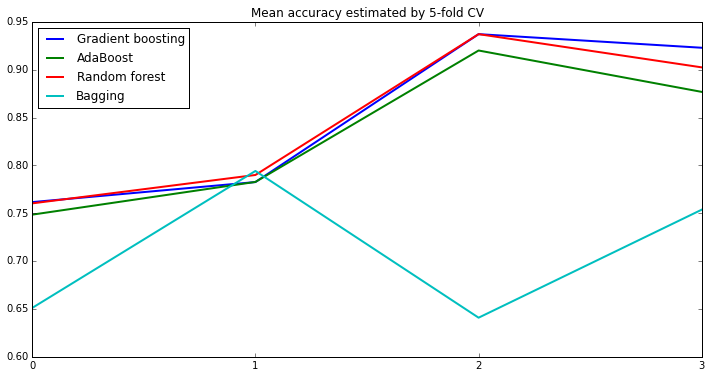

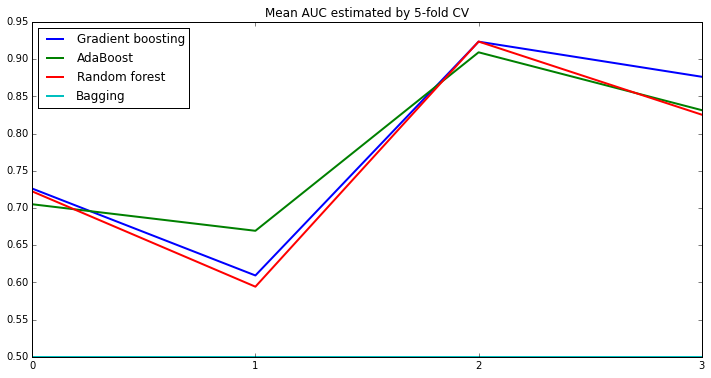

In [233]:
for i in range(len(get_clf_data)):
    print(i, '- ' + get_clf_data[i][0])

# Plotting mean accuracy    
plt.figure(figsize=(12,6))
for clf_name, s in clf_scores.items():
    s = np.array(s)
    plt.plot(s[:, 0], lw=2, label=clf_name)
plt.legend(loc='best')
plt.title('Mean accuracy estimated by 5-fold CV')
plt.xticks(range(len(get_clf_data)))
plt.show()

# Plotting mean AUC
plt.figure(figsize=(12,6))
for clf_name, s in clf_scores.items():
    s = np.array(s)
    plt.plot(s[:, 1], lw=2, label=clf_name)
plt.legend(loc='best')
plt.title('Mean AUC estimated by 5-fold CV')
plt.xticks(range(len(get_clf_data)))
plt.show()

In [228]:
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, \
                            GradientBoostingRegressor, RandomForestRegressor
    
regressors = {'AdaBoost': (AdaBoostRegressor, 
                            {'n_estimators': [10, 50, 100, 200, 500]}),
                'Bagging': (BaggingRegressor,
                            {'n_estimators': [10, 50, 100, 200, 500]}),
               'Gradient boosting': (GradientBoostingRegressor,
                                     {'n_estimators': [10, 50, 100, 200, 500]}),
               'Random forest': (RandomForestRegressor,
                                 {'n_estimators': [10, 50, 100, 200, 500]})}

In [229]:
reg_scores = {}

for reg_name, reg in regressors.items():
    print('\n' + reg_name)
    reg_scores[reg_name] = []
    for dataset, get in get_reg_data:
        print('\n' + dataset + ' dataset:')
        X, y = get()
        reg_scores[reg_name].append(np.mean(test_regressor(X, y, 
            reg[0], reg[1], verbose=True)))


Gradient boosting

Concrete Slump Test dataset:
Iteration 1: 0.229371272022
Iteration 2: 0.528199128381
Iteration 3: 0.661104074954
Iteration 4: 1.34603069794
Iteration 5: 0.158811074523

Airfoil Self-Noise dataset:
Iteration 1: 2.4756716827
Iteration 2: 2.05687619919
Iteration 3: 2.27110187465
Iteration 4: 2.34672343783
Iteration 5: 2.12320995041

Yacht Hydrodynamics dataset:
Iteration 1: 1.07868281921
Iteration 2: 0.558341649306
Iteration 3: 0.599988210826
Iteration 4: 0.710280765242
Iteration 5: 0.742366365646

AdaBoost

Concrete Slump Test dataset:
Iteration 1: 1.12662784526
Iteration 2: 1.56772595104
Iteration 3: 0.620745691438
Iteration 4: 0.439474972937
Iteration 5: 0.357961322226

Airfoil Self-Noise dataset:
Iteration 1: 3.78180511212
Iteration 2: 3.69671688593
Iteration 3: 3.75200182164
Iteration 4: 3.77292815116
Iteration 5: 3.77353994159

Yacht Hydrodynamics dataset:
Iteration 1: 1.62185856503
Iteration 2: 1.28016292219
Iteration 3: 1.52601847149
Iteration 4: 1.81596024151


0 - Concrete Slump Test
1 - Airfoil Self-Noise
2 - Yacht Hydrodynamics


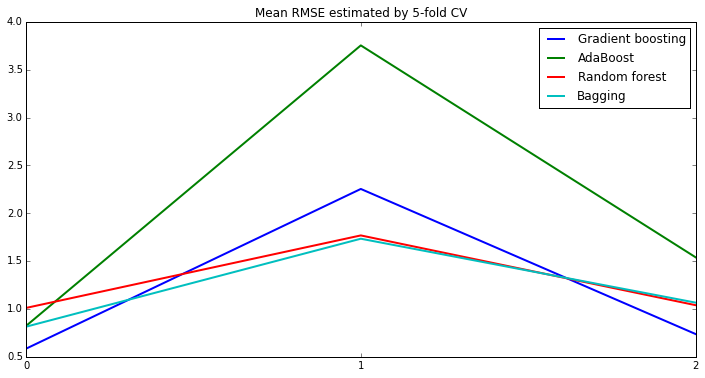

In [230]:
for i in range(len(get_reg_data)):
    print(i, '- ' + get_reg_data[i][0])

# Plotting mean RMSE    
plt.figure(figsize=(12,6))
for reg_name, score in reg_scores.items():
    plt.plot(score, lw=2, label = reg_name)
plt.legend(loc='best')
plt.title('Mean RMSE estimated by 5-fold CV')
plt.xticks(range(len(get_reg_data)))
plt.show()